#  Data Preparation

<b>Data Source</b><br>
We collected our data using the official data from Federal Reserve Economic Data(FRED) https://fred.stlouisfed.org. The <b>time period</b> of this dataset is 10 years monthly data from April 2013 to March 2023.  <br><br>
<b>Data Cleaning</b><br>Our data cleaning process contains the following procedure: <br> <b>    1.</b> Calculate the percentage return of S&P 500 data using the formula: (Current Period - Last Period)*100/Last Period<br>
<b>    2.</b> Scynchronize the data to the same frequency and merge data.<br>
<b>    3.</b> Check for NULL values and use linear trend to fill them.<br>
<b>    4.</b> Calculate other needed data (lags and leads data)<br>

In [1]:
import pandas_datareader as pdr
import pandas as pd
import statsmodels.formula.api as smf
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import statsmodels.api as sm
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings("ignore")

In [2]:
# get uneployment rate
start_date = '2010-04-15'
data = pdr.data.DataReader('UNRATE', 'fred', start_date)
T = len(data)
index = pd.date_range(start = '2010-04',periods = T,freq = 'M')
data.index = index 

In [3]:
data

,UNRATE
2010-04-30,9.6
2010-05-31,9.4
2010-06-30,9.4
2010-07-31,9.5
2010-08-31,9.5
...,...
2022-10-31,3.6
2022-11-30,3.5
2022-12-31,3.4
2023-01-31,3.6


In [4]:
data.isnull().sum()

UNRATE    0
dtype: int64

# I. Data Introduction

The <b>time period</b> of this dataset is 10 years monthly data from April 2010 to March 2023. 

In [5]:
data.describe()

,UNRATE
count,155.000000
mean,5.954194
std,2.201069
min,3.400000
25%,4.000000
50%,5.300000
75%,7.700000
max,14.700000


## 1. Scatter Plot

## 2. Outliers 

# III. Results 
## 1. Modeling and Forecasting Trend
### (a) Time-seires plot

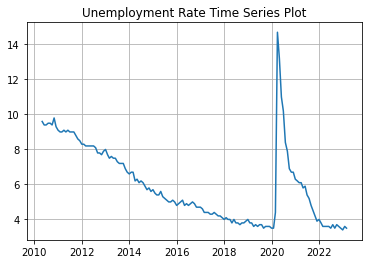

In [6]:
plt.title('Unemployment Rate Time Series Plot')
plt.plot(data['UNRATE'])
plt.grid()

### (b) Stationarity

In [7]:
# ADF Test for Stationarity
from statsmodels.tsa.stattools import adfuller
adf = adfuller(data["UNRATE"])[1]
print(f"p value:{adf}", ", Series is Stationary" if adf <0.05 else ", Series is Non-Stationary")

p value:0.06977178650326507 , Series is Non-Stationary


### (c) ACF and PACF

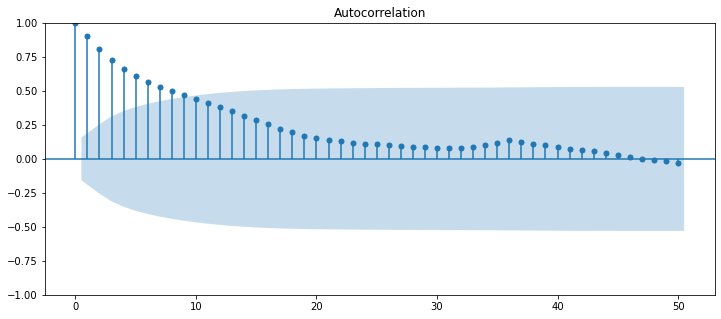

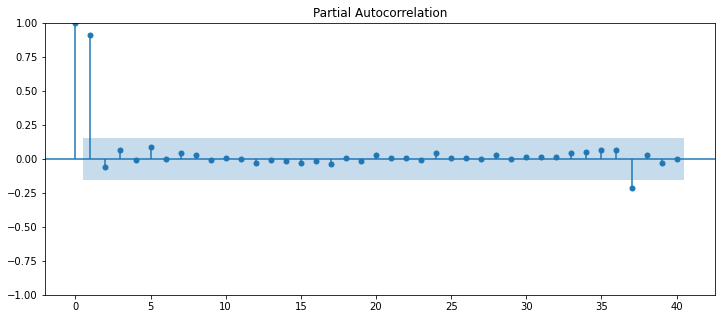

In [8]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# Plot the ACF
fig, ax = plt.subplots(figsize=(12, 5))
plot_acf(data['UNRATE'], lags=50, ax=ax)
plt.show()

# Plot the PACF
fig, ax = plt.subplots(figsize=(12, 5))
plot_pacf(data['UNRATE'], lags=40, ax=ax)
plt.show()

<b> Illustration</b>
1. There are many autocorrelations that are significantly non-zero. Therefore, the time series is non-random.
2. High degree of autocorrelation between adjacent (lag = 14,32) in PACF plot
3. Seasonality and cycle can be spotted in the plots

### (d) Fitted Model 
#### (1) Linear Model

In [9]:
 #add a time variable to the DataFrame
data['time'] = range(1, len(data)+1)

In [10]:
# fit the linear regression model with a linear trend
li_fit = smf.ols('UNRATE ~ time', data=data).fit()

# print the model summary
print(li_fit.summary())

                            OLS Regression Results                            
Dep. Variable:                 UNRATE   R-squared:                       0.396
Model:                            OLS   Adj. R-squared:                  0.392
Method:                 Least Squares   F-statistic:                     100.4
Date:                Wed, 26 Apr 2023   Prob (F-statistic):           1.75e-18
Time:                        01:04:49   Log-Likelihood:                -302.62
No. Observations:                 155   AIC:                             609.2
Df Residuals:                     153   BIC:                             615.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.3616      0.277     30.188      0.0

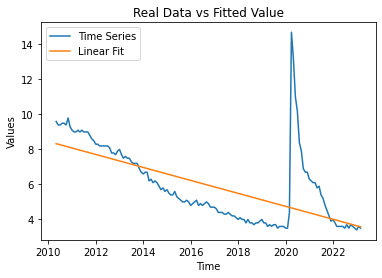

In [11]:
li_y_fit = li_fit.fittedvalues

fig, ax = plt.subplots()
ax.plot(data.index, data['UNRATE'], label='Time Series')
ax.plot(data.index, li_y_fit, label='Linear Fit')
ax.legend()
ax.set_xlabel('Time')
ax.set_ylabel('Values')
ax.set_title('Real Data vs Fitted Value')
plt.show()

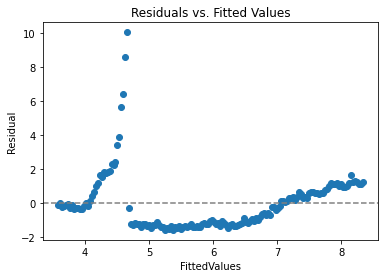

In [12]:
li_y_residual = li_fit.resid

fig, ax = plt.subplots()
ax.scatter(li_y_fit, li_y_residual)
ax.set_xlabel('FittedValues')
ax.set_ylabel('Residual')
ax.set_title('Residuals vs. Fitted Values')
plt.axhline(y=0, color='gray', linestyle='--')
plt.show()

#### (2) Polynomial Model

In [13]:
# fit the linear regression model with a linear trend
po_fit = smf.ols('UNRATE ~ time + I(time**2)', data=data).fit()

# print the model summary
print(po_fit.summary())

                            OLS Regression Results                            
Dep. Variable:                 UNRATE   R-squared:                       0.510
Model:                            OLS   Adj. R-squared:                  0.504
Method:                 Least Squares   F-statistic:                     79.11
Date:                Wed, 26 Apr 2023   Prob (F-statistic):           2.84e-24
Time:                        01:04:52   Log-Likelihood:                -286.43
No. Observations:                 155   AIC:                             578.9
Df Residuals:                     152   BIC:                             588.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       10.0491      0.379     26.545   

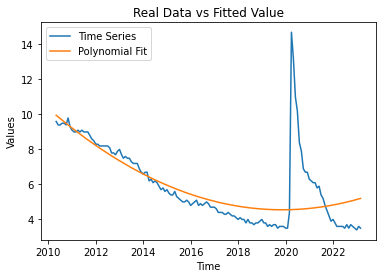

In [14]:
po_y_fit = po_fit.fittedvalues

fig, ax = plt.subplots()
ax.plot(data.index, data['UNRATE'], label='Time Series')
ax.plot(data.index, po_y_fit, label='Polynomial Fit')
ax.legend()
ax.set_xlabel('Time')
ax.set_ylabel('Values')
ax.set_title('Real Data vs Fitted Value')
plt.show()

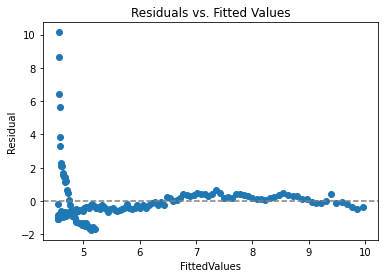

In [15]:
po_y_residual = po_fit.resid

fig, ax = plt.subplots()
ax.scatter(po_y_fit, po_y_residual)
ax.set_xlabel('FittedValues')
ax.set_ylabel('Residual')
ax.set_title('Residuals vs. Fitted Values')
plt.axhline(y=0, color='gray', linestyle='--')
plt.show()

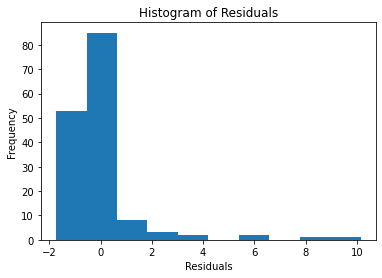

In [16]:
plt.hist(po_y_residual, bins=10)

# Add axis labels and title
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')

# Show the plot
plt.show()

#### (3) Quadratic + Periodic Model

In [17]:
# add a periodic component to the DataFrame with monthly cycle
data['sin_time'] = np.sin(2 * np.pi * data.index.month / 12)
data['cos_time'] = np.cos(2 * np.pi * data.index.month / 12)

# fit a quadratic + periodic model with monthly cycle
qua_period_fit = smf.ols('UNRATE ~ time + np.power(time, 2) + sin_time + cos_time', data=data).fit()

# print the model summary
print(qua_period_fit.summary())

                            OLS Regression Results                            
Dep. Variable:                 UNRATE   R-squared:                       0.523
Model:                            OLS   Adj. R-squared:                  0.510
Method:                 Least Squares   F-statistic:                     41.08
Date:                Wed, 26 Apr 2023   Prob (F-statistic):           3.24e-23
Time:                        01:04:54   Log-Likelihood:                -284.39
No. Observations:                 155   AIC:                             578.8
Df Residuals:                     150   BIC:                             594.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            10.0340      0.37

<b>Comment: </b><br> 1. By adding a leading term the R-squared result(21%) suggests the model is a better fit than linear and similar to the quadratic model. <br>2. The p-value for F-statistic in this model is nearly 0, suggesting that this model is strongly statistically significant.<br> 3. P-value for the t-test of the model parameters shows that the model is statistically significant as well except for the quatratic term.

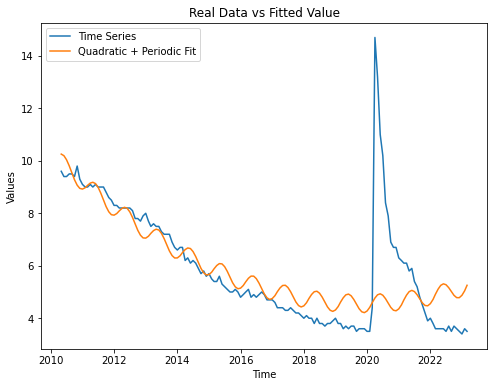

In [18]:
per_y_fit = qua_period_fit.fittedvalues

fig = plt.figure(figsize=(8, 6))
plt.plot(data.index, data['UNRATE'], label='Time Series')
plt.plot(data.index, per_y_fit, label='Quadratic + Periodic Fit')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Values')
plt.title('Real Data vs Fitted Value')
plt.show()

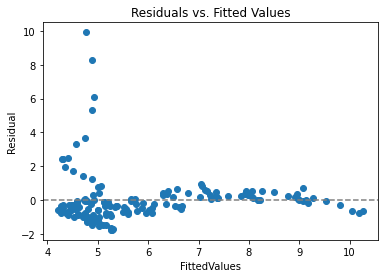

In [19]:
per_y_residual = qua_period_fit.resid

fig, ax = plt.subplots()
ax.scatter(per_y_fit, per_y_residual)
ax.set_xlabel('FittedValues')
ax.set_ylabel('Residual')
ax.set_title('Residuals vs. Fitted Values')
plt.axhline(y=0, color='gray', linestyle='--')
plt.show()

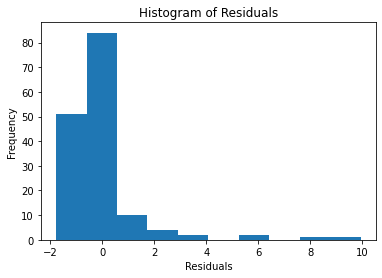

In [20]:
plt.hist(per_y_residual, bins=10)

# Add axis labels and title
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')

# Show the plot
plt.show()

<b>Comment: </b>The residual histogram shows that most residuals are smaller than zero. This means the fitted values are often smaller than actual values. There is also a decay in residuals' frequency.

### (e) AIC and BIC

In [21]:
li_aic = li_fit.aic
po_aic = po_fit.aic
qua_per_aic = qua_period_fit.aic
# compare the AIC values of the different models
print('Linear model AIC:', li_aic)
print('Polynomial model AIC:', po_aic)
print('Quadratic+Periodic model AIC:', qua_per_aic)

Linear model AIC: 609.2393504592224
Polynomial model AIC: 578.8628348720292
Quadratic+Periodic model AIC: 578.7827153881404


In [22]:
li_bic = li_fit.bic
po_bic = po_fit.bic
qua_per_bic = qua_period_fit.bic
# compare the BIC values of the different models
print('Linear model BIC:', li_bic)
print('Polynomial model BIC:', po_bic)
print('Quadratic+Periodic model AIC:', qua_per_bic)

Linear model BIC: 615.3262006930609
Polynomial model BIC: 587.993110222787
Quadratic+Periodic model AIC: 593.9998409727367


<b> Comment: </b> <br> AIC indicates that quadratic+periodic model is the best and BIC indicates that the polynomial model is the best.

### (f) Forecasting with Polynomial Model

In [23]:
data.index

DatetimeIndex(['2010-04-30', '2010-05-31', '2010-06-30', '2010-07-31',
               '2010-08-31', '2010-09-30', '2010-10-31', '2010-11-30',
               '2010-12-31', '2011-01-31',
               ...
               '2022-05-31', '2022-06-30', '2022-07-31', '2022-08-31',
               '2022-09-30', '2022-10-31', '2022-11-30', '2022-12-31',
               '2023-01-31', '2023-02-28'],
              dtype='datetime64[ns]', length=155, freq='M')

In [24]:
# extract the starting date and the end dat for my forecast horizon
dates_fore = pd.date_range(start = '2023-02-01', end = '2024-03-01', freq = 'MS')

# get the names of each month for the forecast horizon
month = dates_fore.month_name()

# get the trend variable for the forecast horizon, starting at the end of the original
t = np.arange(156, 156+14)

# put into a format accepted by statsmodels
new = pd.DataFrame({'Month': month, 'time':t}, index = dates_fore)

In [25]:
pred = po_fit.get_prediction(new)
pred_mean = pred.predicted_mean
pred_ci = pred.conf_int(alpha=0.05)
pred_ci_pd=pd.DataFrame(pred_ci,columns=['lb','ub'],index = dates_fore)
new=pd.concat([new,pred_ci_pd],axis=1)

In [26]:
new

,Month,time,lb,ub
2023-02-01,February,156,4.486288,5.982152
2023-03-01,March,157,4.500904,6.035611
2023-04-01,April,158,4.515984,6.090259
2023-05-01,May,159,4.531534,6.146091
2023-06-01,June,160,4.547557,6.203103
2023-07-01,July,161,4.564057,6.261292
2023-08-01,August,162,4.581037,6.320654
2023-09-01,September,163,4.598502,6.381185
2023-10-01,October,164,4.616454,6.442882
2023-11-01,November,165,4.634897,6.505743


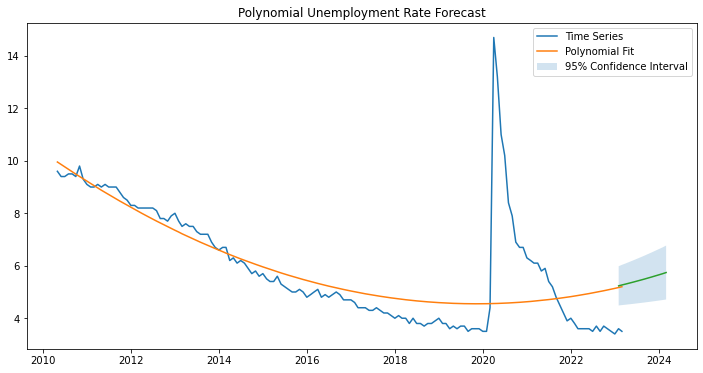

In [27]:
plt.figure(figsize = (12, 6))
plt.title('Polynomial Unemployment Rate Forecast')
plt.plot(data.index, data['UNRATE'], label='Time Series')
plt.plot(data.index, po_y_fit, label='Polynomial Fit')

# make (using the predict method) and plot predictions 
plt.plot(po_fit.predict(new))

plt.fill_between(new.index, pred_ci_pd['lb'], pred_ci_pd['ub'], alpha=0.2, label='95% Confidence Interval')

# set the legend and display the plot
plt.legend()
plt.show()

<b> Comment: </b> <br> We use the polynomial model since it has almost same AIC value as quadratic+periodic model but has lower BIC value than the quadratic+periodic model. We estimate the 95% confidence interval for predicted values and put it in the graph above.

## 2. Trend and Seansonal Adjustments
### (a) Additive Decomposition 

In [28]:
from statsmodels.graphics.tsaplots import month_plot, seasonal_plot, plot_acf, plot_pacf, quarter_plot

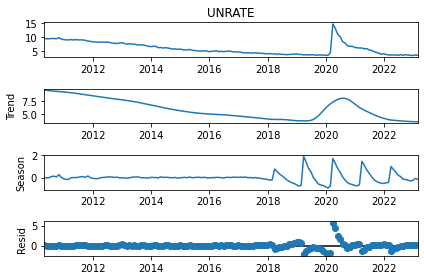

In [29]:
# Perform the additive decomposition
stl = STL(data['UNRATE']).fit()
fig = stl.plot()

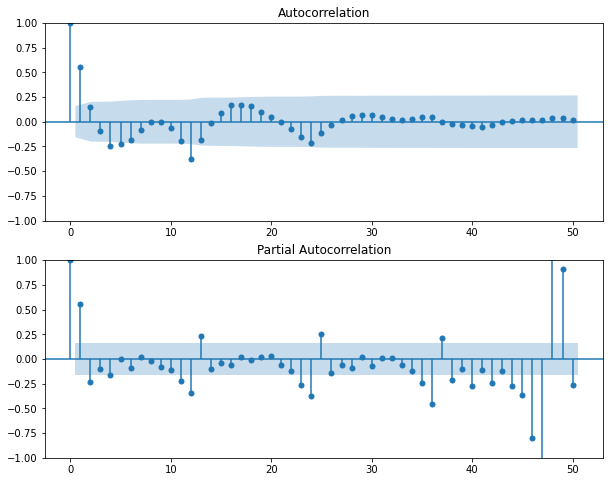

In [30]:
# Extract residuals from the fitted STL model
residuals = stl.resid

# Plot ACF and PACF of residuals
fig, axes = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(residuals, lags=50, ax=axes[0])
plot_pacf(residuals, lags=50, ax=axes[1])
plt.show()

<b> Comments </b> <br> The PACF plot shows significant correlation at larger lags (e.g., 37-50) but not at smaller lags (e.g., 2-35), this suggests the presence of a long-term dependence or seasonality in the time series data. Specifically, it indicates that the current value of the time series is more strongly influenced by values that occurred many lags ago, rather than more recent values.

### (b) Multiplicative Decomposition

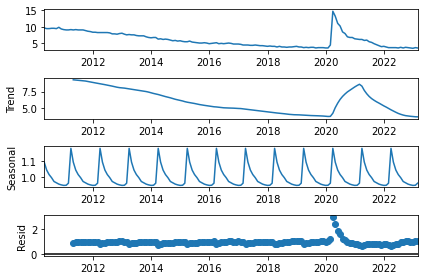

In [31]:
# Perform the multiplicative decomposition
mul_de = seasonal_decompose(data[['UNRATE']],model = "multiplicative",two_sided = False)
mul_de.plot();

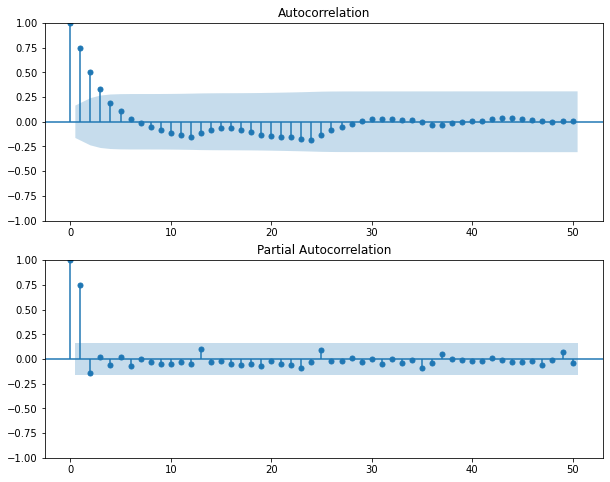

In [32]:
# Extract residuals from the fitted multiplicative decompose model
residuals = mul_de.resid.dropna()

# Plot ACF and PACF of residuals
fig, axes = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(residuals, lags=50, ax=axes[0])
plot_pacf(residuals, lags=50, ax=axes[1])
plt.show()

<b> Comments </b> <br> The PACF plot shows similar correlation as lag increases from 2 to 50, which is very small. This suggests that there is not so much dependence or seasonality in the time series data. However, in the ACF plot, the correlation when lag is relatively small is greater than the correlation when lag is big. It indicates that the current value of the time series is more strongly influenced by values that occurred recently, rather than values that occured long times ago.

### (c) Decomposition Comparison

Since the PACF plot for additive decomposition shows high correlation when lag is big but PACF plot for multiplicative decomposition is constant and small for all lags, multiplicative decomposition is better. The residual errors of multiplicative decomposition is white noise (random and uncorrelated). The additive decomposition produces residual errors with correlations, so it suggests that the additive decomposition may not be capturing all the underlying patterns in the data.

### (d) Model Analysis

Since the residuals from multiplicative decomposition are white noise but the residuals from additive decomposition are not white noise, it suggests that the random components have different characteristics. Thus the models for the cycles will be different.

### (e) Seasonal Factors

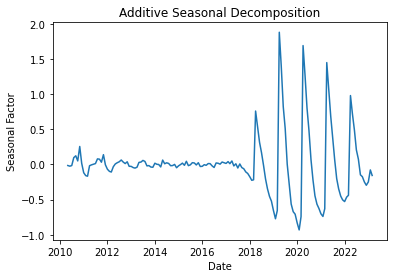

In [33]:
# extract seasonal component for additive decomposition
seasonal_add = stl.seasonal

# plot seasonal component
plt.plot(seasonal_add)
plt.xlabel('Date')
plt.ylabel('Seasonal Factor')
plt.title('Additive Seasonal Decomposition')
plt.show()

<b> Comments </b> <br> The seasonal factor is far less fluctuating from 2010 to 2018 than the seasonal factor from 2018 to now in additive seasonal decomposition. The seasonal factors for first few years are small since the seasonal variations may be drowned out by noise.

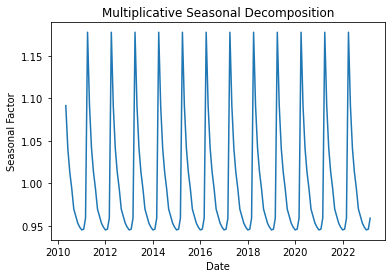

In [34]:
# extract seasonal component for multiplicative decomposition
seasonal_mult = mul_de.seasonal

# plot seasonal component
plt.plot(seasonal_mult)
plt.xlabel('Date')
plt.ylabel('Seasonal Factor')
plt.title('Multiplicative Seasonal Decomposition')
plt.show()

<b> Comments </b> <br> The seasonal factor is fluctuating at same magnitude from 2010 to now in multiplicative seasonal decomposition. The seasonal factors across these years are very stationary and they are all positive numbers around 1.

### (f) Trend and Seasonal Model Forecasting

In [35]:
data['Month']=data.index.month_name()

In [36]:
data

,UNRATE,time,sin_time,cos_time,Month
2010-04-30,9.6,1,8.660254e-01,-0.500000,April
2010-05-31,9.4,2,5.000000e-01,-0.866025,May
2010-06-30,9.4,3,1.224647e-16,-1.000000,June
2010-07-31,9.5,4,-5.000000e-01,-0.866025,July
2010-08-31,9.5,5,-8.660254e-01,-0.500000,August
...,...,...,...,...,...
2022-10-31,3.6,151,-8.660254e-01,0.500000,October
2022-11-30,3.5,152,-5.000000e-01,0.866025,November
2022-12-31,3.4,153,-2.449294e-16,1.000000,December
2023-01-31,3.6,154,5.000000e-01,0.866025,January


In [37]:
tas_fit = smf.ols('UNRATE ~ time + I(time**2) + Month', data=data).fit()
print(tas_fit.summary())

                            OLS Regression Results                            
Dep. Variable:                 UNRATE   R-squared:                       0.530
Model:                            OLS   Adj. R-squared:                  0.487
Method:                 Least Squares   F-statistic:                     12.23
Date:                Wed, 26 Apr 2023   Prob (F-statistic):           1.60e-17
Time:                        01:05:02   Log-Likelihood:                -283.19
No. Observations:                 155   AIC:                             594.4
Df Residuals:                     141   BIC:                             637.0
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             10.4948      0

In [38]:
# extract the starting date and the end dat for my forecast horizon
dates_fore1 = pd.date_range(start = '2023-02-01', end = '2024-01-01', freq = 'MS')

# get the names of each month for the forecast horizon
month1 = dates_fore1.month_name()

# get the trend variable for the forecast horizon, starting at the end of the original
t1 = np.arange(156, 156+12)

# put into a format accepted by statsmodels
newnew = pd.DataFrame({'Month': month1, 'time':t1}, index = dates_fore1)

In [39]:
newnew

,Month,time
2023-02-01,February,156
2023-03-01,March,157
2023-04-01,April,158
2023-05-01,May,159
2023-06-01,June,160
2023-07-01,July,161
2023-08-01,August,162
2023-09-01,September,163
2023-10-01,October,164
2023-11-01,November,165


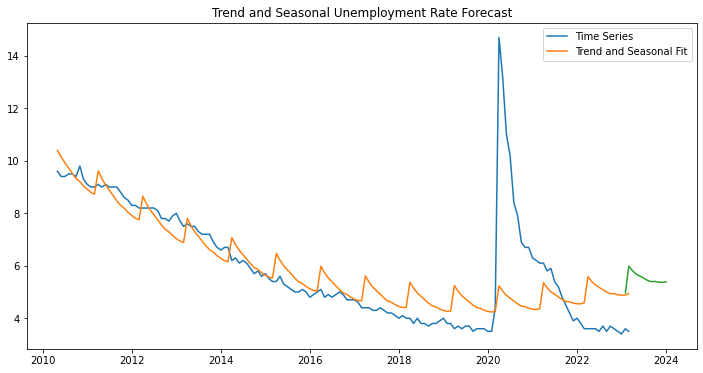

In [40]:
plt.figure(figsize = (12, 6))
plt.title('Trend and Seasonal Unemployment Rate Forecast')
plt.plot(data.index, data['UNRATE'], label='Time Series')
plt.plot(data.index, tas_fit.fittedvalues, label='Trend and Seasonal Fit')

# make (using the predict method) and plot predictions 
plt.plot(tas_fit.predict(newnew))

# set the legend and display the plot
plt.legend()
plt.show()

<b> Comments </b> <br> We fit a model which is very similar to the polynomial model, except that we add a month dummy variable in the equation. We forecast 12 months ahead, above is the plot of the data, respective fit, and forecast.